# Run Time Parameters


## Goals


* Introduce the concept of runtime parameters (RTPs)

* Explore how RTPs can be specified to control the application

* Build and run our new application with RTPs

---


We are going to explore the concept of runtime parameters (RTPs), expanding on the ideas a software kernel. RTPs are scalar parameters that are passed to the kernel and updated at runtime. They can be used as coefficients for filter values, or adjustable color thresholds, or anywhere that requires a parameter that can be adjusted by a user.

We will use the `%%kernel` magic to specify and build a software kernel that applies a threshold to the red channel (R) of our RGBA input image.  We will demonstrate how to vary the threshold level via an RTP. We will then build our application using the same `RGB720pBuilder` template graph, the mapped data flow graph we saw previously. This time, we will alter the RTPs while the application is running, varying the threshold computation for each execution and observing the change in the output. 

---


## A _threshold_ Kernel

Instead of the pass-through kernel, we will construct a new one that applies a threshold to the red channel of the RGBA image. Once again, we start by importing the `npu` module.

In [1]:
import npu

The `%%kernel` magic is used to create the Python kernel object, specifying the kernel C++ code that runs on the AI Engine of our compute tile. Notice the difference in the function signature compared to our previous kernel.  Our new function declares an extra scalar parameter, called `r_threshold` of type `uint8_t`.  

`r_threshold` is our RTP that we will use to vary the threshold level between calls.

In [2]:
%%kernel 

void threshold(uint8_t *in_buffer, uint8_t *out_buffer, uint32_t nbytes, uint8_t r_threshold)
{
    for(int i=0; i<nbytes; i+=4) {
        uint8_t new_r;
        
        // Apply threshold and update output buffer
        new_r = in_buffer[i] < r_threshold ? 0 : 255;
        out_buffer[i] = new_r;
        
        // The remaining bytes of the RGBA pixel are unaffected by the red channel threshold
        out_buffer[i+1] = in_buffer[i+1];
        out_buffer[i+2] = in_buffer[i+2];
        out_buffer[i+3] = in_buffer[i+3];
    }
}

We can notice some slight differences with this kernel compared to our pass-through example in the previous notebook:

1. We are now iterating over 4-Byte at a time for each RGBA pixel as we will only modify the red channel.
2. We are conditionally setting the first value (red channel) of the iteration based on a threshold `r_threshold`, the RTP.

### Configure and build the application

Next, we instantiate an object of type `RGB720pBuilder` and parameterize it with our `threshold` Python kernel object as shown below.

In [3]:
from npu.lib.graphs.graph_1ct import RGB720pBuilder

import numpy as np
img_in = np.zeros(shape=(720,1280,4), dtype=np.uint8)
img_out = np.zeros(shape=(720,1280,4), dtype=np.uint8)

app_builder = RGB720pBuilder(kernel=threshold)
app_builder.build(img_in, img_out)

Building the threshold kernel...
Building the xclbin...
Successfully Building Application... threshold.xclbin & threshold.seq delivered



---


## Running the Application

Running our new application is similar to the previous example, with one exception: we need to assign a value to our new runtime parameter `r_threshold`. 

Start by loading the input image:

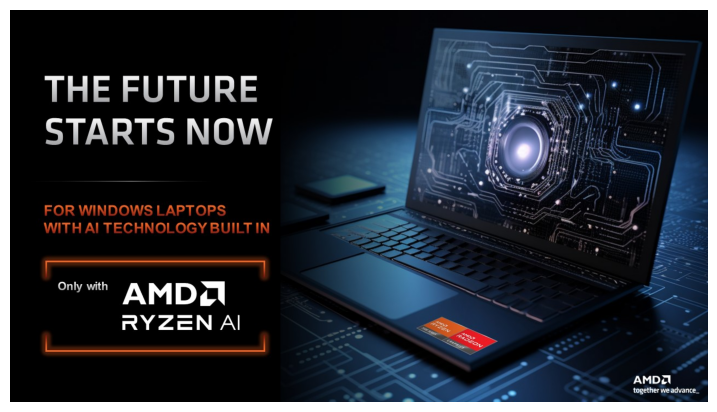

In [4]:
from npu.utils import OpenCVImageReader, image_plot

img = OpenCVImageReader('images/jpg/ryzenai_future_starts_now.jpg').img
image_plot(img)

Next, load the newly created application, allocate our buffers for our input and output images, and sync the input to the npu. 

In [5]:
from npu.runtime import AppRunner
import numpy as np

app = AppRunner('threshold.xclbin')

# Allocate app input and output buffers to exchange data with NPU
input_image = app.allocate(shape=(720,1280,4), dtype=np.uint8)
output_image = app.allocate(shape=(720,1280,4), dtype=np.uint8)

# Load RGBA 720p image into input_image buffer
input_image[:] = img
input_image.sync_to_npu()

### Set the RTP value

The `r_threshold` RTP value needs to be set before calling our application.

An application has an attribute for each kernel instantiated within it. We can access this attribute by using `app.metadata`. Run the following cell and expand the kernels field.

In [ ]:
app.metadata

Expanding *kernels* in the above cell, we can see that we have an instance of our threshold kernel called `threshold_0`. If we expand the *ports* for that kernel, we can see our `r_threshold` RTP. Expanding `r_threshold`, we can see that it is a runtime parameter (RTP) with an initial value of 128. You can also use the search function to seek for this RTP.

Change the value of the RTP to 64:

In [7]:
app.threshold_0.r_threshold.value = 64

With the RTP value changed, we can use `app.call()` to pass the input and output buffers to the application.

`output_image.sync_from_npu()` is a blocking call to make sure the data in the output buffer is up to date before we use it. 

In [8]:
# Run app on NPU
app.call(input_image, output_image)
output_image.sync_from_npu()

### Display the result

The output buffer now has the resulting image from the NPU. We can display this image:

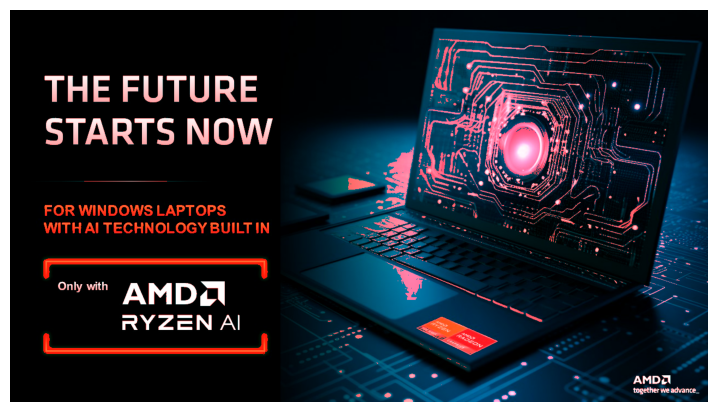

In [9]:
image_plot(output_image)

### Create a function to update the RTP and display the result

Let us create a Python function to set our RTP more easily and inspect the result:

In [10]:
def run_threshold(threshold_value=64):
    app.threshold_0.r_threshold.value = threshold_value
    app.call(input_image, output_image)
    output_image.sync_from_npu()
    image_plot(output_image)

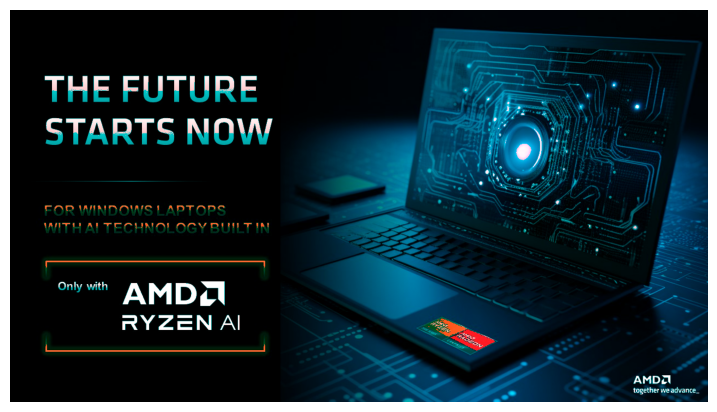

In [11]:
run_threshold(200)

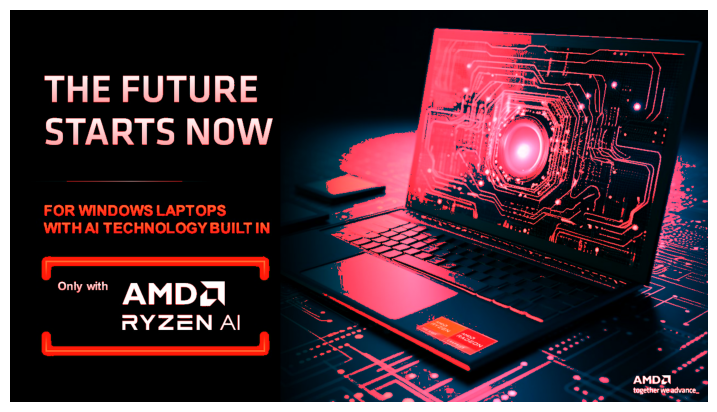

In [12]:
run_threshold(32)

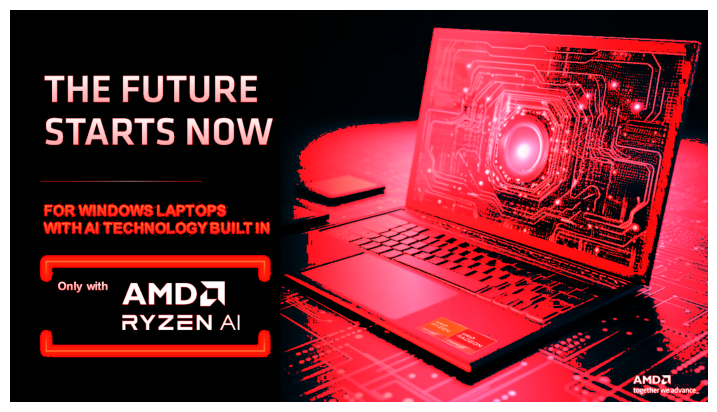

In [13]:
run_threshold(10)

<div class="alert alert-box alert-warning">
    Do not forget to tidy up after running your application.
</div>

In [14]:
del app


---


## Running the NPU in a Loop

Now, we can run our application in a loop, passing the same image into the array as quickly as possible, and add an [IPython widget](https://ipywidgets.readthedocs.io/en/latest/) to vary the RTP at runtime. In this case, we will assign an integer slider with a range of [0, 255] to the `r_threshold` RTP.

We will use the same compiled binary file (`threshold.xclbin`), but this time we are going to use the Riallto `ImageLooper720p` visualization helper class. Unlike the `app.call()` method which only process a one frame for each invocation of the kernel, this helper class will transfer images continuously in a loop. Note that each individual image is still processed one row at the time.


In [15]:
from npu.lib.graphs.image_looper_720p import ImageLooper720p

app = ImageLooper720p(img='images/jpg/ryzenai_future_starts_now.jpg', 
                      xclbin='threshold.xclbin', 
                      rtps={"r_threshold" : { "type": "slider", "min": 0, "max" : 255}})

Start the new application and move the slider to observe the result.

In [16]:
app.start()

Image(value=b'', format='jpeg')

Button(description='Stop', style=ButtonStyle())

### Application performance

<div class="alert alert-box alert-info">

Notice there is some delay between the change in the RTP and the image update.

</div>

The relatively slow response to RTP changes is due to the performance of the software kernel running on the AI Engine. 

The software kernel is running on the scalar processor and has not been optimized to use the SIMD capabilities of the AI Engine. In the next sections you will see how to use fine-grained parallelism and vector operations in the compute tile to improve the performance of the application.


---


## Exercise for the Reader:

Instead of one RTP affecting just the red channel, can you implement a kernel with three RTPs, one for each to control the threshold on the red, green and blue channels?

Using the following kernel function signature, write your code in the cell below and execute the cell:

In [ ]:
%%kernel

void my_threshold(uint8_t *in_buffer, uint8_t *out_buffer, uint32_t nbytes, uint8_t r_threshold, uint32_t g_threshold, uint32_t b_threshold)
{
    // Your kernel code here <<<<<<
}

Run the cell below to build your new application.

In [ ]:
my_threshold_app = RGB720pBuilder(kernel=my_threshold)
my_threshold_app.build(img_in, img_out)

Once it has built, run the following cells to load your application and display the output.

In [ ]:
from npu.lib.graphs.image_looper_720p import ImageLooper720p

app = ImageLooper720p(img='images/jpg/ryzenai_future_starts_now.jpg', 
                      xclbin='my_threshold.xclbin', 
                      rtps={"r_threshold" : { "type": "slider", "min": 0, "max" : 255},
                            "g_threshold" : { "type": "slider", "min": 0, "max" : 255},
                            "b_threshold" : { "type": "slider", "min": 0, "max" : 255}})

In [ ]:
app.start()


---


## Next Steps

In the next notebook you are going to learn how to write vectorized kernels to fully utilize the vector processor.


---

<center>
Copyright&copy; 2023 AMD, Inc
</center>
<center>
SPDX-License-Identifier: MIT
</center>